In [1]:
import dash
import dash_core_components as dcc
import dash_html_components as html
from dash.dependencies import Input, Output

import pandas as pd
import numpy as np
import pmdarima as pm
from IPython.display import display, HTML

import matplotlib.pylab as plt
from matplotlib.pylab import rcParams
import matplotlib.dates as mdates
rcParams['figure.figsize'] = 16, 10
%matplotlib inline
import matplotlib as mpl

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from datetime import datetime as dt

import warnings

In [2]:
df = pd.read_csv("https://raw.githubusercontent.com/willoutcault/NYC_Accidents_ARIMA_Forcast/master/Accidents.csv")
df['Month'] = pd.to_datetime(df['Month'], infer_datetime_format=True)
df = df.set_index(['Month'])
print(df)
warnings.filterwarnings('ignore')
indexedDataset = df[0:91]

            Accidents
Month                
2012-07-01      16991
2012-08-01      17141
2012-09-01      16534
2012-10-01      16863
2012-11-01      15889
...               ...
2020-01-01      14276
2020-02-01      13671
2020-03-01      11021
2020-04-01       4059
2020-05-01       1244

[95 rows x 1 columns]


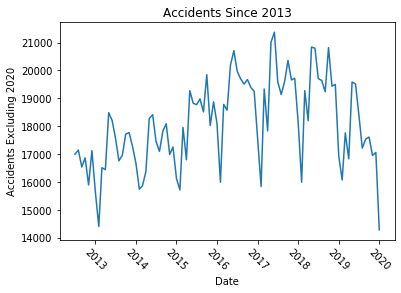

In [3]:
plt.xlabel("Date")
plt.ylabel("Accidents Excluding 2020")
plt.title("Accidents Since 2013")
plt.xticks(rotation=-45)
plt.plot(indexedDataset)

In [4]:
def test_stationarity(timeseries):
    movingAverage = timeseries.rolling(window=12).mean()
    movingStd = timeseries.rolling(window=12).std()
    
    orig = plt.plot(timeseries, color='darkgreen', label='Original')
    mean = plt.plot(movingAverage, color='blue', label='Rolling Mean')
    std = plt.plot(movingStd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries['Accidents'], autolag = 'AIC')

    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    
    print(dfoutput)

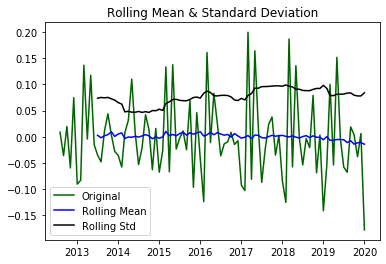

Results of Dickey-Fuller Test:
Test Statistic                 -1.086181
p-value                         0.720551
#Lags Used                     12.000000
Number of Observations Used    77.000000
Critical Value (1%)            -3.518281
Critical Value (5%)            -2.899878
Critical Value (10%)           -2.587223
dtype: float64


In [5]:
# Getting Log Value
indexedDataset_logScale = np.log(indexedDataset)
# Subtracting Rolling Average And STD
movingAverage = indexedDataset_logScale.rolling(window=12).mean()
movingStd = indexedDataset_logScale.rolling(window=12).std()
datasetLogScaleMinusMovingAverage = indexedDataset_logScale - movingAverage
datasetLogScaleMinusMovingAverage.dropna(inplace=True)
# Time-Shift The Data (1 Degree)
datasetLogDiffShifting = indexedDataset_logScale - indexedDataset_logScale.shift(1)
datasetLogDiffShifting.dropna(inplace=True)
test_stationarity(datasetLogDiffShifting)

In [6]:
%%capture
# Optimizing Parameters (p,q,m)
smodel = pm.auto_arima(indexedDataset_logScale['Accidents'], start_p=1, start_q=1,
                         test='adf',
                         max_p=3, max_q=3, m=12,
                         start_P=0, seasonal=True,
                         d=None, D=1, trace=True,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True);

In [7]:
n_periods = 24

fitted, confint = smodel.predict(n_periods=n_periods, return_conf_int=True)
index_of_fc = pd.date_range(indexedDataset_logScale.index[-1], periods = n_periods, freq='MS')

# make series for plotting purpose
fitted_series = pd.Series(fitted, index=index_of_fc)
lower_series = np.exp(pd.Series(confint[:, 0], index=index_of_fc))
upper_series = np.exp(pd.Series(confint[:, 1], index=index_of_fc))    

def plot_forecast(smodel, indexedDataset_logScale, n_periods):

    fig = go.Figure()

    fig.add_trace(go.Scatter(
        x=indexedDataset_logScale.iloc[:,0].index, 
        y=np.exp(indexedDataset_logScale.iloc[:,0].values),
        mode='lines+markers',
        name='Actual'))

    fig.add_trace(go.Scatter(
        x=fitted_series.index, 
        y=np.exp(fitted_series.values),
        mode='lines+markers',
        line_color='rgba(232,68,68,1)',
        name='Forecast'))

    fig.add_trace(go.Scatter(
        x=fitted_series.index,
        y=lower_series,
        fill='tonexty',
        showlegend=False,
        fillcolor='rgba(246,194,194,.5)',
        line_color='rgba(246,194,194,.5)',
        name = "Forecast"))

    fig.add_trace(go.Scatter(
        x=fitted_series.index,
        y=upper_series,
        fill='tonexty',
        showlegend=False,
        fillcolor='rgba(246,194,194,.5)',
        line_color='rgba(246,194,194,.5)',
        name = "Forecast"))


    fig.update_layout(title='2012 - 2019 Auto Accidents with Projections',
                       xaxis_title='Month',
                       yaxis_title='Accidents')

    fig.show()
    
    
plot_forecast(smodel, indexedDataset_logScale, 18)

NameError: name 'go' is not defined

In [ ]:
import plotly.graph_objects as go

def plot_year(fitted_series, df):
    
    fig = go.Figure()
    
    fig.add_trace(go.Scatter(x=fitted_series[2:].index, y=np.exp(fitted_series[2:].values),
                mode='lines',
                name='Fitted Series',
                line=dict(dash='dot', width=4)))
    
    fig.add_trace(go.Scatter(x=df.iloc[68:,0].index, y=df.iloc[68:,0].values,
                mode='lines+markers',
                name='Actual'))
    
    fig.update_layout(title='Current Day Auto Accidents',
               xaxis_title='Month',
               yaxis_title='Accidents')
    
    fig.show()
    
plot_year(fitted_series, df)

In [ ]:
def create_table(fitted_series, df):
    fitted_series_scaled = np.exp(fitted_series).round(decimals=0).astype(object)
    perc_change = (fitted_series_scaled.values[0:4]-df.values[90:94,0])/fitted_series_scaled.values[0:4]*(-100)
    dt = pd.DataFrame({"Month":df.index[90:94], "Projections":fitted_series_scaled.values[0:4],
                  "Actual":df.values[90:94,0], "Percent Change":perc_change})
    print(dt)
create_table(fitted_series, df)

In [ ]:
from IPython import display
import os
def show_app(app, port = 9999, 
             width = 700, 
             height = 350, 
             offline = False,
            in_binder = None):
    in_binder ='JUPYTERHUB_SERVICE_PREFIX' in os.environ if in_binder is None else in_binder
    if in_binder:
        base_prefix = '{}proxy/{}/'.format(os.environ['JUPYTERHUB_SERVICE_PREFIX'], port)
        url = 'https://hub.mybinder.org{}'.format(base_prefix)
        app.config.requests_pathname_prefix = base_prefix
    else:
        url = 'http://localhost:%d' % port
        
    iframe = '<a href="{url}" target="_new">Open in new window</a><hr><iframe src="{url}" width={width} height={height}></iframe>'.format(url = url, 
                                                                                  width = width, 
                                                                                  height = height)
    
    display.display_html(iframe, raw = True)
    if offline:
        app.css.config.serve_locally = True
        app.scripts.config.serve_locally = True
    return app.run_server(debug=False, # needs to be false in Jupyter
                          host = '0.0.0.0',
                          port=port)

In [ ]:
app = dash.Dash()

app.layout = html.Div(children=[
    html.H1(children='NYC Tree Health'),

    html.Div(children='''
        Dash: Data608 Module 3 - Examining NYC Tree Health Using Dash App.
    '''),

    dcc.Graph(
        id='example-graph',
        figure={
            'data': [
                {'x': df.index, 'y': df.Good, 'type': 'bar', 'name': 'Good'},
                {'x': df.index, 'y': df.Fair, 'type': 'bar', 'name': 'Fair'},
                {'x': df.index, 'y': df.Poor, 'type': 'bar', 'name': 'Poor'}
            ],
            'layout': {
                'title': 'NYC Tree Condition by Borough'
            }
        }
    ),
    dcc.Graph(
        id='example-graph-2',
        figure={
            'data': [
                {'x': df2.index, 'y': df2.Good, 'type': 'scatter', 'name': 'Good'}
            ],
            'layout': {
                'title': 'Steward Health Versus Good Tree Health'
            }
        }
    ),
    dcc.Graph(
        id='example-graph-3',
        figure={
            'data': [
                {'x': df2.index, 'y': df2.Fair, 'type': 'scatter', 'name': 'Fair'}
            ],
            'layout': {
                'title': 'Steward Health Versus Fair Tree Health'
            }
        }
    ),
    dcc.Graph(
        id='example-graph-4',
        figure={
            'data': [
                {'x': df2.index, 'y': df2.Poor, 'type': 'scatter', 'name': 'Poor'}
            ],
            'layout': {
                'title': 'Steward Impact Versus Poor Tree Health'
            }
        }
    )
])

In [ ]:
show_app(app)